In [1]:
import sys
sys.path.append('..')

from models import basic_dnn_regression
from develop.file_listing import *

from sklearn import metrics
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.svm import SVR

In [2]:
def load_dat(dat_type, beta_num):
    
    ckpt_path = "./out/deeppain/"
    basedir = '/media/cocoan-gpu1/wani8T/data/deeppain_standard_bt_study'
    
    if dat_type.lower() == 'train':
        in_condition_1 = ['study01_bmrk3', 'study02_bmrk4', 'study03_nsf', 'study04_ie', 'study05_exp', 'study06_ilcp']
        in_condition_2 = ['subject']
        out_conidtion = ['nopain','subject031','subject032','subject033','subject059','subject060','subject061',
                     'subject085','subject086','subject087','subject135','subject136','subject137',
                     'subject152','subject153','subject154','subject181','subject182','subject183']
        
    elif dat_type.lower() == 'test':
        in_condition_1 = ['study01_bmrk3', 'study02_bmrk4', 'study03_nsf', 'study04_ie', 'study05_exp', 'study06_ilcp']
        in_condition_2 = ['subject031','subject032','subject033','subject059','subject060','subject061',
                         'subject085','subject086','subject087','subject135','subject136','subject137',
                         'subject152','subject153','subject154','subject181','subject182','subject183']
        out_conidtion = ['nopain']

    # Making Beta list
    search_list = dir_search(basedir=basedir, in_condition_1=in_condition_1, 
                         in_condition_2 = in_condition_2, 
                         out_conidtion=out_conidtion)
    
    beta_full_path_list = beta_file_list(search_list, beta_num)
    
    # Making Rating list

    in_condition_1 = ['study01_bmrk3', 'study02_bmrk4', 'study03_nsf', 'study04_ie', 'study05_exp', 'study06_ilcp']
    in_condition_2 = ['rating_csv']
    out_conidtion = ['nopain']
    
    rating_full_path_list = rating_file_list(basedir, in_condition_1, 
                                    in_condition_2, out_conidtion=out_conidtion)
    
    
    y = []
    for i in tqdm_notebook(range(len(beta_full_path_list))):
        beta_name = os.path.split(beta_full_path_list[i])[1]
        subject_number = os.path.split(os.path.split(beta_full_path_list[i])[0])[1]

        for j in range(len(rating_full_path_list)):
            if subject_number in rating_full_path_list[j]:
                pd_rating = pd.read_csv(rating_full_path_list[j])
                rating = pd_rating.loc[pd_rating['beta_index'] == beta_name, ['rating_standard_bt_study']].values[0][0]
                y.append(rating)
                
    y = np.array(y)
    y = y[:,np.newaxis]
    y = y.astype('f4')

    data_shape = np.load(beta_full_path_list[0]).flatten().shape
    X = np.empty((len(beta_full_path_list),data_shape[0]))

    for i in tqdm_notebook(range(len(beta_full_path_list))):
        temp_data = np.load(beta_full_path_list[i]).flatten()
        X[i] = temp_data           

    X = X.astype('f4')
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    
    return  X, y
                

In [3]:
X_train, y_train = load_dat('train',15)

In [4]:
X_test, y_test = load_dat('test',30)

# Making DNN graph

In [5]:
def batch_norm(data, is_train, name=None):
    return tf.layers.batch_normalization(data, training=is_train, name=name)

def R_squared(y, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.div(residual, total))
    return r2

In [6]:
num_classes = 1

In [7]:
#Graph reset
tf.reset_default_graph()

x = tf.placeholder(tf.float32,shape=[None, X_train.shape[1]])
y_true = tf.placeholder(tf.float32,shape=[None,num_classes])
is_train = tf.placeholder(tf.bool)
hold_prob = tf.placeholder(tf.float32)

layer_1 = tf.layers.dense(x, 256)
layer_1_bath_norm = batch_norm(layer_1, is_train, name=None)
layer_1_relu = tf.nn.relu(layer_1_bath_norm)

layer_2 = tf.layers.dense(layer_1_relu, 128)
layer_2_bath_norm = batch_norm(layer_2, is_train, name=None)
layer_2_relu = tf.nn.relu(layer_2_bath_norm)

layer_3 = tf.layers.dense(layer_2_relu, 64)
layer_3_bath_norm = batch_norm(layer_3, is_train, name=None)
layer_3_relu = tf.nn.relu(layer_3_bath_norm)

layer_4 = tf.layers.dense(layer_3_relu, 1)
layer_4 = tf.nn.sigmoid(layer_4)

y_pred = layer_4

mse = tf.losses.mean_squared_error(y_true, y_pred)
learning_rate = 1e-7
optimizer = tf.train.AdamOptimizer(learning_rate)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train = optimizer.minimize(mse)

In [8]:
#Learning Steps
step_size = 300000

#Data number counts
train_data_num = int(X_train.shape[0])
test_data_num = int(X_test.shape[0])

step_data_num = 100

j_cut = int(train_data_num/step_data_num)
t_cut = int(test_data_num/step_data_num)

In [9]:
ckpt_path = "./out/deep_pain_basic_dnn/"
train_r2_list = []
train_mse_list = []
test_r2_list = []
test_mse_list = []
step_list = []

highest_test_r2=None
lowest_test_mse=None

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    summary_writer = tf.summary.FileWriter(ckpt_path, sess.graph)
    for i in range(step_size):
        j = i%j_cut
        t = i%t_cut
        
        if i>0 and i%100==0:
            X_train, y_train = load_dat('train',15)
        

        r2 = R_squared(y_true, y_pred)
        _, train_mse, train_r2 = sess.run([train, mse, r2], feed_dict={x: X_train[j*step_data_num:j*step_data_num+step_data_num], 
                                                           y_true: y_train[j*step_data_num:j*step_data_num+step_data_num], 
                                                           hold_prob: 0.5, is_train:True})

        test_mse, test_r2= sess.run([mse, r2], feed_dict={x: X_test[t*step_data_num:t*step_data_num+step_data_num], 
                                                          y_true: y_test[t*step_data_num:t*step_data_num+step_data_num], is_train:False})
        
        summ = tf.Summary()
        summ.value.add(tag="train R2", simple_value=train_r2)
        summ.value.add(tag="train mse", simple_value=train_mse)
        summ.value.add(tag="test R2", simple_value=test_r2)
        summ.value.add(tag="test mse", simple_value=test_mse)

        summary_writer.add_summary(summ,i)
        
        train_r2_list.append(train_r2)
        train_mse_list.append(train_mse)
        test_r2_list.append(test_r2)
        test_mse_list.append(test_mse)
        step_list.append(i)
        
        
        if highest_test_r2 == None or highest_test_r2 <  test_r2:
            highest_test_r2 = test_r2
            saver.save(sess, ckpt_path+"basic_dnn_highest_test_r2.ckpt")
        if lowest_test_mse == None or lowest_test_mse >  test_mse:
            lowest_test_mse = test_mse
            saver.save(sess, ckpt_path+"basic_dnn_lowest_mse.ckpt")
        
        
        if i % 101 == 0:
            print('Currently on step {}'.format(i))
            print('##Train mse is: {}'.format(train_mse))
            print('##Train r2 is: {}'.format(train_r2))
            print('\n') 
            print('##Test mse is: {}'.format(test_mse))
            print('##Test r2 is: {}'.format(test_r2))
            print('\n')      

Currently on step 0
##Train mse is: 1.1747413873672485
##Train r2 is: -0.6432380676269531


##Test mse is: 1.8328338861465454
##Test r2 is: -0.049605607986450195





Currently on step 101
##Train mse is: 1.3246058225631714
##Train r2 is: 0.01917940378189087


##Test mse is: 0.7971926927566528
##Test r2 is: -0.20749974250793457





Currently on step 202
##Train mse is: 1.0954798460006714
##Train r2 is: 0.024614930152893066


##Test mse is: 1.3175216913223267
##Test r2 is: -0.5114742517471313





Currently on step 303
##Train mse is: 0.8361119627952576
##Train r2 is: -0.5667668581008911


##Test mse is: 0.7220199704170227
##Test r2 is: -0.047704100608825684





Currently on step 404
##Train mse is: 1.0674974918365479
##Train r2 is: 0.08750331401824951


##Test mse is: 1.0704690217971802
##Test r2 is: -0.0004220008850097656





Currently on step 505
##Train mse is: 0.7529608011245728
##Train r2 is: 0.19733411073684692


##Test mse is: 1.7176024913787842
##Test r2 is: 0.016383707523345947





Currently on step 606
##Train mse is: 0.8988364338874817
##Train r2 is: 0.044574856758117676


##Test mse is: 0.6770315766334534
##Test r2 is: -0.02549290657043457





Currently on step 707
##Train mse is: 0.8149968981742859
##Train r2 is: -0.049964070320129395


##Test mse is: 1.2223234176635742
##Test r2 is: -0.40226197242736816





Currently on step 808
##Train mse is: 1.0995373725891113
##Train r2 is: 0.276131272315979


##Test mse is: 0.697572648525238
##Test r2 is: -0.012229204177856445





Currently on step 909
##Train mse is: 0.743848443031311
##Train r2 is: -0.12856054306030273


##Test mse is: 1.0878136157989502
##Test r2 is: -0.016631603240966797





Currently on step 1010
##Train mse is: 0.7071353793144226
##Train r2 is: -0.08027517795562744


##Test mse is: 1.6829017400741577
##Test r2 is: 0.03625577688217163





Currently on step 1111
##Train mse is: 0.7976131439208984
##Train r2 is: -0.08860123157501221


##Test mse is: 0.678203821182251
##Test r2 is: -0.027268528938293457





Currently on step 1212
##Train mse is: 1.1952108144760132
##Train r2 is: -0.08488178253173828


##Test mse is: 1.2087584733963013
##Test r2 is: -0.3867000341415405





Currently on step 1313
##Train mse is: 0.6005889773368835
##Train r2 is: 0.34046489000320435


##Test mse is: 0.6802014112472534
##Test r2 is: 0.012977659702301025





Currently on step 1414
##Train mse is: 1.0158442258834839
##Train r2 is: 0.20592159032821655


##Test mse is: 1.093021273612976
##Test r2 is: -0.021498441696166992





Currently on step 1515
##Train mse is: 1.0340816974639893
##Train r2 is: -1.1925997734069824


##Test mse is: 1.6693071126937866
##Test r2 is: 0.0440409779548645





Currently on step 1616
##Train mse is: 0.9324621558189392
##Train r2 is: 0.038263022899627686


##Test mse is: 0.6828338503837585
##Test r2 is: -0.03428161144256592





Currently on step 1717
##Train mse is: 0.5754984021186829
##Train r2 is: 0.365547776222229


##Test mse is: 1.2058556079864502
##Test r2 is: -0.38336992263793945





Currently on step 1818
##Train mse is: 0.36795613169670105
##Train r2 is: 0.2624861001968384


##Test mse is: 0.6894558668136597
##Test r2 is: -0.00045120716094970703





Currently on step 1919
##Train mse is: 1.0752125978469849
##Train r2 is: 0.04040372371673584


##Test mse is: 1.0920722484588623
##Test r2 is: -0.02061152458190918





Currently on step 2020
##Train mse is: 0.7857313752174377
##Train r2 is: 0.06511926651000977


##Test mse is: 1.6452785730361938
##Test r2 is: 0.05780130624771118





Currently on step 2121
##Train mse is: 0.7324515581130981
##Train r2 is: 0.29328739643096924


##Test mse is: 0.6821200847625732
##Test r2 is: -0.03320038318634033





Currently on step 2222
##Train mse is: 0.9015406966209412
##Train r2 is: -0.03587830066680908


##Test mse is: 1.2102465629577637
##Test r2 is: -0.38840723037719727





Currently on step 2323
##Train mse is: 0.789469838142395
##Train r2 is: 0.17426562309265137


##Test mse is: 0.686998188495636
##Test r2 is: 0.0031149983406066895





Currently on step 2424
##Train mse is: 0.8247111439704895
##Train r2 is: -0.027971863746643066


##Test mse is: 1.0919448137283325
##Test r2 is: -0.02049243450164795





Currently on step 2525
##Train mse is: 1.1044551134109497
##Train r2 is: 0.239219069480896


##Test mse is: 1.6400631666183472
##Test r2 is: 0.06078803539276123





Currently on step 2626
##Train mse is: 0.5539138913154602
##Train r2 is: 0.39972442388534546


##Test mse is: 0.6830207705497742
##Test r2 is: -0.03456473350524902





Currently on step 2727
##Train mse is: 0.5711808204650879
##Train r2 is: -0.28969502449035645


##Test mse is: 1.2113959789276123
##Test r2 is: -0.38972580432891846





Currently on step 2828
##Train mse is: 0.9105038642883301
##Train r2 is: 0.14623433351516724


##Test mse is: 0.6785839200019836
##Test r2 is: 0.015324771404266357





Currently on step 2929
##Train mse is: 0.49775856733322144
##Train r2 is: 0.4212890863418579


##Test mse is: 1.0861523151397705
##Test r2 is: -0.015079021453857422





Currently on step 3030
##Train mse is: 0.7336564064025879
##Train r2 is: 0.2541808485984802


##Test mse is: 1.6360256671905518
##Test r2 is: 0.06310021877288818





Currently on step 3131
##Train mse is: 0.6330403685569763
##Train r2 is: 0.25023365020751953


##Test mse is: 0.6899929046630859
##Test r2 is: -0.045125365257263184





Currently on step 3232
##Train mse is: 0.9665763974189758
##Train r2 is: 0.39484715461730957


##Test mse is: 1.2148208618164062
##Test r2 is: -0.39365482330322266





Currently on step 3333
##Train mse is: 0.7557612061500549
##Train r2 is: -0.13128042221069336


##Test mse is: 0.6729316711425781
##Test r2 is: 0.02352660894393921





Currently on step 3434
##Train mse is: 0.5469388961791992
##Train r2 is: 0.01075291633605957


##Test mse is: 1.0817173719406128
##Test r2 is: -0.010934233665466309





Currently on step 3535
##Train mse is: 0.7061876058578491
##Train r2 is: -0.12338447570800781


##Test mse is: 1.6383945941925049
##Test r2 is: 0.06174355745315552





Currently on step 3636
##Train mse is: 1.171099066734314
##Train r2 is: 0.030426859855651855


##Test mse is: 0.6927511096000671
##Test r2 is: -0.04930317401885986





Currently on step 3737
##Train mse is: 0.4027281105518341
##Train r2 is: 0.4860774278640747


##Test mse is: 1.2166926860809326
##Test r2 is: -0.39580225944519043





Currently on step 3838
##Train mse is: 0.798875629901886
##Train r2 is: 0.3119593858718872


##Test mse is: 0.6679205298423767
##Test r2 is: 0.030798137187957764





Currently on step 3939
##Train mse is: 0.8563932180404663
##Train r2 is: -0.9574179649353027


##Test mse is: 1.0844566822052002
##Test r2 is: -0.013494372367858887





Currently on step 4040
##Train mse is: 0.679075300693512
##Train r2 is: 0.29683834314346313


##Test mse is: 1.6375137567520142
##Test r2 is: 0.062248051166534424





Currently on step 4141
##Train mse is: 0.6282309889793396
##Train r2 is: 0.428031861782074


##Test mse is: 0.701093316078186
##Test r2 is: -0.06193900108337402





Currently on step 4242
##Train mse is: 0.3073351979255676
##Train r2 is: 0.4660620093345642


##Test mse is: 1.2129909992218018
##Test r2 is: -0.39155566692352295





Currently on step 4343
##Train mse is: 0.8606774806976318
##Train r2 is: 0.13820260763168335


##Test mse is: 0.6731470227241516
##Test r2 is: 0.02321404218673706





Currently on step 4444
##Train mse is: 0.7126563191413879
##Train r2 is: 0.11611253023147583


##Test mse is: 1.0790550708770752
##Test r2 is: -0.008446216583251953





Currently on step 4545
##Train mse is: 0.6319804191589355
##Train r2 is: 0.32699692249298096


##Test mse is: 1.636539340019226
##Test r2 is: 0.06280606985092163





Currently on step 4646
##Train mse is: 0.9194812774658203
##Train r2 is: -0.07429039478302002


##Test mse is: 0.704983115196228
##Test r2 is: -0.06783092021942139





Currently on step 4747
##Train mse is: 0.682302713394165
##Train r2 is: 0.22227203845977783


##Test mse is: 1.20775306224823
##Test r2 is: -0.3855466842651367





Currently on step 4848
##Train mse is: 0.698899507522583
##Train r2 is: 0.15373510122299194


##Test mse is: 0.6652705669403076
##Test r2 is: 0.034643471240997314





Currently on step 4949
##Train mse is: 0.7909719347953796
##Train r2 is: 0.41292256116867065


##Test mse is: 1.0788624286651611
##Test r2 is: -0.008266091346740723





Currently on step 5050
##Train mse is: 0.7349810600280762
##Train r2 is: 0.3845192790031433


##Test mse is: 1.6276110410690308
##Test r2 is: 0.06791895627975464





Currently on step 5151
##Train mse is: 0.6168003082275391
##Train r2 is: -0.5168390274047852


##Test mse is: 0.7087388038635254
##Test r2 is: -0.07351946830749512





Currently on step 5252
##Train mse is: 0.6759774088859558
##Train r2 is: 0.3643251657485962


##Test mse is: 1.2172316312789917
##Test r2 is: -0.3964204788208008





Currently on step 5353
##Train mse is: 0.5869206190109253
##Train r2 is: 0.48723775148391724


##Test mse is: 0.674551248550415
##Test r2 is: 0.021176457405090332





Currently on step 5454
##Train mse is: 0.663421094417572
##Train r2 is: 0.3854404091835022


##Test mse is: 1.0758569240570068
##Test r2 is: -0.005457282066345215





Currently on step 5555
##Train mse is: 0.5242791175842285
##Train r2 is: 0.4662014842033386


##Test mse is: 1.6192203760147095
##Test r2 is: 0.07272404432296753





Currently on step 5656
##Train mse is: 0.9933667182922363
##Train r2 is: 0.430728018283844


##Test mse is: 0.7080405354499817
##Test r2 is: -0.07246196269989014





Currently on step 5757
##Train mse is: 0.6728354692459106
##Train r2 is: 0.14567041397094727


##Test mse is: 1.2171813249588013
##Test r2 is: -0.3963627815246582





Currently on step 5858
##Train mse is: 0.47134703397750854
##Train r2 is: 0.06592106819152832


##Test mse is: 0.6669442653656006
##Test r2 is: 0.03221476078033447





Currently on step 5959
##Train mse is: 0.6326587796211243
##Train r2 is: 0.15471458435058594


##Test mse is: 1.0691189765930176
##Test r2 is: 0.0008397102355957031





Currently on step 6060
##Train mse is: 0.9150801301002502
##Train r2 is: 0.21193206310272217


##Test mse is: 1.6183031797409058
##Test r2 is: 0.07324928045272827





Currently on step 6161
##Train mse is: 0.3164936304092407
##Train r2 is: 0.5767239332199097


##Test mse is: 0.7103619575500488
##Test r2 is: -0.07597815990447998





Currently on step 6262
##Train mse is: 0.6513876914978027
##Train r2 is: 0.419147253036499


##Test mse is: 1.2109068632125854
##Test r2 is: -0.38916468620300293





Currently on step 6363
##Train mse is: 0.7629824876785278
##Train r2 is: -0.35490500926971436


##Test mse is: 0.6728808879852295
##Test r2 is: 0.023600339889526367





Currently on step 6464
##Train mse is: 0.5761730074882507
##Train r2 is: 0.42719048261642456


##Test mse is: 1.072792649269104
##Test r2 is: -0.002593517303466797





Currently on step 6565
##Train mse is: 0.582737147808075
##Train r2 is: 0.47128331661224365


##Test mse is: 1.6189738512039185
##Test r2 is: 0.07286524772644043





Currently on step 6666
##Train mse is: 0.276955783367157
##Train r2 is: 0.5425639748573303


##Test mse is: 0.7090710401535034
##Test r2 is: -0.07402276992797852





Currently on step 6767
##Train mse is: 0.8337149620056152
##Train r2 is: 0.21310299634933472


##Test mse is: 1.2166937589645386
##Test r2 is: -0.39580345153808594





Currently on step 6868
##Train mse is: 0.6097419261932373
##Train r2 is: 0.3452381491661072


##Test mse is: 0.6756613254547119
##Test r2 is: 0.0195656418800354





Currently on step 6969
##Train mse is: 0.6162540912628174
##Train r2 is: 0.44298940896987915


##Test mse is: 1.0741976499557495
##Test r2 is: -0.003906607627868652





Currently on step 7070
##Train mse is: 0.7470992207527161
##Train r2 is: 0.031898438930511475


##Test mse is: 1.6229442358016968
##Test r2 is: 0.07059156894683838





Currently on step 7171
##Train mse is: 0.6159133315086365
##Train r2 is: 0.33926546573638916


##Test mse is: 0.7182436585426331
##Test r2 is: -0.08791637420654297





Currently on step 7272
##Train mse is: 0.6421413421630859
##Train r2 is: 0.2551388144493103


##Test mse is: 1.2343270778656006
##Test r2 is: -0.41603267192840576





Currently on step 7373
##Train mse is: 0.7783088088035583
##Train r2 is: 0.4567981958389282


##Test mse is: 0.6691596508026123
##Test r2 is: 0.02900010347366333





Currently on step 7474
##Train mse is: 0.45929449796676636
##Train r2 is: 0.5349535942077637


##Test mse is: 1.0715492963790894
##Test r2 is: -0.0014314651489257812





Currently on step 7575
##Train mse is: 0.5061628222465515
##Train r2 is: -0.22881674766540527


##Test mse is: 1.6166366338729858
##Test r2 is: 0.07420367002487183





Currently on step 7676
##Train mse is: 0.8880705237388611
##Train r2 is: 0.29251569509506226


##Test mse is: 0.7135604619979858
##Test r2 is: -0.08082294464111328





Currently on step 7777
##Train mse is: 0.46184754371643066
##Train r2 is: 0.5555840730667114


##Test mse is: 1.2273367643356323
##Test r2 is: -0.40801334381103516





Currently on step 7878
##Train mse is: 0.6345632076263428
##Train r2 is: 0.422136127948761


##Test mse is: 0.6706520915031433
##Test r2 is: 0.026834428310394287





Currently on step 7979
##Train mse is: 0.4827449917793274
##Train r2 is: 0.42643576860427856


##Test mse is: 1.072301983833313
##Test r2 is: -0.0021349191665649414





Currently on step 8080
##Train mse is: 0.8960410952568054
##Train r2 is: 0.4579033851623535


##Test mse is: 1.6241769790649414
##Test r2 is: 0.06988561153411865





Currently on step 8181
##Train mse is: 0.6759359836578369
##Train r2 is: 0.004893958568572998


##Test mse is: 0.7185736298561096
##Test r2 is: -0.0884162187576294





Currently on step 8282
##Train mse is: 0.43035033345222473
##Train r2 is: 0.3175070881843567


##Test mse is: 1.2251476049423218
##Test r2 is: -0.4055018424987793





Currently on step 8383
##Train mse is: 0.6349433660507202
##Train r2 is: 0.08692061901092529


##Test mse is: 0.6699531078338623
##Test r2 is: 0.02784872055053711





Currently on step 8484
##Train mse is: 0.9275104403495789
##Train r2 is: 0.16220319271087646


##Test mse is: 1.0831286907196045
##Test r2 is: -0.012253284454345703





Currently on step 8585
##Train mse is: 0.3410075306892395
##Train r2 is: 0.6015279293060303


##Test mse is: 1.6213574409484863
##Test r2 is: 0.07150024175643921





Currently on step 8686
##Train mse is: 0.6711341142654419
##Train r2 is: 0.4532719850540161


##Test mse is: 0.7078976631164551
##Test r2 is: -0.07224547863006592





Currently on step 8787
##Train mse is: 0.76735520362854
##Train r2 is: -0.3452693223953247


##Test mse is: 1.2327388525009155
##Test r2 is: -0.41421055793762207





Currently on step 8888
##Train mse is: 0.6133329272270203
##Train r2 is: 0.30714601278305054


##Test mse is: 0.6653894186019897
##Test r2 is: 0.034470975399017334





Currently on step 8989
##Train mse is: 0.4955728054046631
##Train r2 is: 0.48707103729248047


##Test mse is: 1.077985167503357
##Test r2 is: -0.0074462890625





Currently on step 9090
##Train mse is: 0.2710352838039398
##Train r2 is: 0.5600355863571167


##Test mse is: 1.6205146312713623
##Test r2 is: 0.07198286056518555





Currently on step 9191
##Train mse is: 0.760356605052948
##Train r2 is: 0.32800227403640747


##Test mse is: 0.708652138710022
##Test r2 is: -0.07338821887969971





Currently on step 9292
##Train mse is: 0.6281440854072571
##Train r2 is: 0.29543250799179077


##Test mse is: 1.2258596420288086
##Test r2 is: -0.40631866455078125





Currently on step 9393
##Train mse is: 0.6199912428855896
##Train r2 is: 0.4237859845161438


##Test mse is: 0.6717246770858765
##Test r2 is: 0.02527797222137451





Currently on step 9494
##Train mse is: 0.795051634311676
##Train r2 is: 0.11009734869003296


##Test mse is: 1.0728411674499512
##Test r2 is: -0.0026388168334960938





Currently on step 9595
##Train mse is: 0.5979318618774414
##Train r2 is: 0.3091300129890442


##Test mse is: 1.6270947456359863
##Test r2 is: 0.06821465492248535





Currently on step 9696
##Train mse is: 0.5164159536361694
##Train r2 is: 0.3826488256454468


##Test mse is: 0.7089794278144836
##Test r2 is: -0.0738840103149414





Currently on step 9797
##Train mse is: 0.5935714244842529
##Train r2 is: 0.5052071809768677


##Test mse is: 1.227321743965149
##Test r2 is: -0.40799593925476074





Currently on step 9898
##Train mse is: 0.4162132143974304
##Train r2 is: 0.483579158782959


##Test mse is: 0.6643756031990051
##Test r2 is: 0.03594207763671875





Currently on step 9999
##Train mse is: 0.5839883089065552
##Train r2 is: -0.09681844711303711


##Test mse is: 1.0718897581100464
##Test r2 is: -0.0017497539520263672





Currently on step 10100
##Train mse is: 0.5997189879417419
##Train r2 is: 0.45640772581100464


##Test mse is: 1.6299747228622437
##Test r2 is: 0.06656539440155029





Currently on step 10201
##Train mse is: 0.39990517497062683
##Train r2 is: 0.5761617422103882


##Test mse is: 0.7147235870361328
##Test r2 is: -0.08258461952209473





Currently on step 10302
##Train mse is: 0.7220807671546936
##Train r2 is: 0.4307315945625305


##Test mse is: 1.2244272232055664
##Test r2 is: -0.40467536449432373





Currently on step 10403
##Train mse is: 0.4934614300727844
##Train r2 is: 0.45793992280960083


##Test mse is: 0.6794037818908691
##Test r2 is: 0.014135122299194336





Currently on step 10504
##Train mse is: 0.9273231625556946
##Train r2 is: 0.4423513412475586


##Test mse is: 1.0716174840927124
##Test r2 is: -0.0014952421188354492





Currently on step 10605
##Train mse is: 0.538249671459198
##Train r2 is: 0.2100394368171692


##Test mse is: 1.6228606700897217
##Test r2 is: 0.07063937187194824





Currently on step 10706
##Train mse is: 0.42857420444488525
##Train r2 is: 0.40461474657058716


##Test mse is: 0.7085743546485901
##Test r2 is: -0.07327044010162354





Currently on step 10807
##Train mse is: 0.6015427112579346
##Train r2 is: 0.05755895376205444


##Test mse is: 1.218017578125
##Test r2 is: -0.3973221778869629





Currently on step 10908
##Train mse is: 0.8729990124702454
##Train r2 is: 0.2452968955039978


##Test mse is: 0.663175642490387
##Test r2 is: 0.03768324851989746





Currently on step 11009
##Train mse is: 0.27603575587272644
##Train r2 is: 0.6271438002586365


##Test mse is: 1.0714250802993774
##Test r2 is: -0.001315474510192871





Currently on step 11110
##Train mse is: 0.6549170017242432
##Train r2 is: 0.4505627751350403


##Test mse is: 1.6225366592407227
##Test r2 is: 0.07082498073577881





Currently on step 11211
##Train mse is: 0.6977821588516235
##Train r2 is: -0.1967787742614746


##Test mse is: 0.7087702751159668
##Test r2 is: -0.07356727123260498





Currently on step 11312
##Train mse is: 0.6112252473831177
##Train r2 is: 0.4421846866607666


##Test mse is: 1.2242616415023804
##Test r2 is: -0.40448546409606934





Currently on step 11413
##Train mse is: 0.5121787786483765
##Train r2 is: 0.5147697925567627


##Test mse is: 0.6671488881111145
##Test r2 is: 0.03191781044006348





Currently on step 11514
##Train mse is: 0.3106994926929474
##Train r2 is: 0.5444460511207581


##Test mse is: 1.075585961341858
##Test r2 is: -0.0052040815353393555





Currently on step 11615
##Train mse is: 0.7820862531661987
##Train r2 is: 0.28851938247680664


##Test mse is: 1.6258518695831299
##Test r2 is: 0.06892639398574829





Currently on step 11716
##Train mse is: 0.6321542263031006
##Train r2 is: 0.34027671813964844


##Test mse is: 0.7042072415351868
##Test r2 is: -0.06665563583374023





Currently on step 11817
##Train mse is: 0.5619285702705383
##Train r2 is: 0.45002102851867676


##Test mse is: 1.2266192436218262
##Test r2 is: -0.40719008445739746





Currently on step 11918
##Train mse is: 0.8505519032478333
##Train r2 is: -0.05990743637084961


##Test mse is: 0.6583794355392456
##Test r2 is: 0.04464292526245117





Currently on step 12019
##Train mse is: 0.5530941486358643
##Train r2 is: 0.30664879083633423


##Test mse is: 1.071690559387207
##Test r2 is: -0.0015635490417480469





Currently on step 12120
##Train mse is: 0.5582540035247803
##Train r2 is: 0.2659679651260376


##Test mse is: 1.6243096590042114
##Test r2 is: 0.06980955600738525





Currently on step 12221
##Train mse is: 0.6799117922782898
##Train r2 is: 0.48315978050231934


##Test mse is: 0.7103284597396851
##Test r2 is: -0.07592737674713135





Currently on step 12322
##Train mse is: 0.47629082202911377
##Train r2 is: 0.5053763389587402


##Test mse is: 1.226284146308899
##Test r2 is: -0.4068056344985962





Currently on step 12423
##Train mse is: 0.519848644733429
##Train r2 is: -0.08661830425262451


##Test mse is: 0.6658818125724792
##Test r2 is: 0.03375643491744995





Currently on step 12524
##Train mse is: 0.7998833656311035
##Train r2 is: 0.42587220668792725


##Test mse is: 1.074928879737854
##Test r2 is: -0.0045899152755737305





Currently on step 12625
##Train mse is: 0.33475035429000854
##Train r2 is: 0.6071763038635254


##Test mse is: 1.6178674697875977
##Test r2 is: 0.07349884510040283





Currently on step 12726
##Train mse is: 0.6150224208831787
##Train r2 is: 0.42247408628463745


##Test mse is: 0.7114788293838501
##Test r2 is: -0.07766985893249512





Currently on step 12827
##Train mse is: 0.41686004400253296
##Train r2 is: 0.558407723903656


##Test mse is: 1.2272659540176392
##Test r2 is: -0.4079320430755615





Currently on step 12928
##Train mse is: 0.9473286271095276
##Train r2 is: 0.47059738636016846


##Test mse is: 0.6613101363182068
##Test r2 is: 0.04039031267166138





Currently on step 13029
##Train mse is: 0.48904457688331604
##Train r2 is: 0.12449747323989868


##Test mse is: 1.0682204961776733
##Test r2 is: 0.0016794800758361816





Currently on step 13130
##Train mse is: 0.4858447015285492
##Train r2 is: 0.38620245456695557


##Test mse is: 1.6260873079299927
##Test r2 is: 0.06879156827926636





Currently on step 13231
##Train mse is: 0.5349921584129333
##Train r2 is: 0.2050601840019226


##Test mse is: 0.7049146890640259
##Test r2 is: -0.06772720813751221





Currently on step 13332
##Train mse is: 0.9855576157569885
##Train r2 is: 0.15797674655914307


##Test mse is: 1.235594630241394
##Test r2 is: -0.4174867868423462





Currently on step 13433
##Train mse is: 0.2674948573112488
##Train r2 is: 0.6179019808769226


##Test mse is: 0.6577323079109192
##Test r2 is: 0.04558199644088745





Currently on step 13534
##Train mse is: 0.5185077786445618
##Train r2 is: 0.49270111322402954


##Test mse is: 1.072448968887329
##Test r2 is: -0.002272367477416992





Currently on step 13635
##Train mse is: 0.6623176336288452
##Train r2 is: -1.4064526557922363


##Test mse is: 1.6270766258239746
##Test r2 is: 0.06822508573532104





Currently on step 13736
##Train mse is: 0.6169386506080627
##Train r2 is: 0.37164366245269775


##Test mse is: 0.7029497027397156
##Test r2 is: -0.0647507905960083





Currently on step 13837
##Train mse is: 0.530235767364502
##Train r2 is: 0.5071048736572266


##Test mse is: 1.2190052270889282
##Test r2 is: -0.39845526218414307





Currently on step 13938
##Train mse is: 0.24079400300979614
##Train r2 is: 0.5923455953598022


##Test mse is: 0.666420578956604
##Test r2 is: 0.03297466039657593





Currently on step 14039
##Train mse is: 0.8266394138336182
##Train r2 is: 0.26923471689224243


##Test mse is: 1.0664405822753906
##Test r2 is: 0.003342926502227783





Currently on step 14140
##Train mse is: 0.5562071204185486
##Train r2 is: 0.28022438287734985


##Test mse is: 1.6214877367019653
##Test r2 is: 0.07142561674118042





Currently on step 14241
##Train mse is: 0.4893606901168823
##Train r2 is: 0.4904214143753052


##Test mse is: 0.7056251764297485
##Test r2 is: -0.06880331039428711





Currently on step 14342
##Train mse is: 0.7425249218940735
##Train r2 is: 0.1599332094192505


##Test mse is: 1.2165005207061768
##Test r2 is: -0.39558184146881104





Currently on step 14443
##Train mse is: 0.6070358157157898
##Train r2 is: 0.39118945598602295


##Test mse is: 0.6557239294052124
##Test r2 is: 0.048496246337890625





Currently on step 14544
##Train mse is: 0.516791820526123
##Train r2 is: 0.3888675570487976


##Test mse is: 1.0725878477096558
##Test r2 is: -0.002402067184448242





Currently on step 14645
##Train mse is: 0.6088210344314575
##Train r2 is: 0.5244091749191284


##Test mse is: 1.61745023727417
##Test r2 is: 0.0737377405166626





Currently on step 14746
##Train mse is: 0.4560943841934204
##Train r2 is: 0.4500238299369812


##Test mse is: 0.7110302448272705
##Test r2 is: -0.07699036598205566





Currently on step 14847
##Train mse is: 0.36418673396110535
##Train r2 is: 0.17365974187850952


##Test mse is: 1.2233654260635376
##Test r2 is: -0.40345728397369385





Currently on step 14948
##Train mse is: 0.5859401226043701
##Train r2 is: 0.4288533926010132


##Test mse is: 0.6561461687088013
##Test r2 is: 0.047883570194244385





Currently on step 15049
##Train mse is: 0.41312071681022644
##Train r2 is: 0.5865034461021423


##Test mse is: 1.0732935667037964
##Test r2 is: -0.003061652183532715





Currently on step 15150
##Train mse is: 0.6334154009819031
##Train r2 is: 0.39504027366638184


##Test mse is: 1.6215176582336426
##Test r2 is: 0.07140851020812988





Currently on step 15251
##Train mse is: 0.4133678078651428
##Train r2 is: 0.4839169979095459


##Test mse is: 0.7002484798431396
##Test r2 is: -0.06065940856933594





Currently on step 15352
##Train mse is: 0.9729872941970825
##Train r2 is: 0.4661480784416199


##Test mse is: 1.211072325706482
##Test r2 is: -0.3893544673919678





Currently on step 15453
##Train mse is: 0.552838921546936
##Train r2 is: 0.2299097180366516


##Test mse is: 0.6579747796058655
##Test r2 is: 0.04523015022277832





Currently on step 15554
##Train mse is: 0.3737073838710785
##Train r2 is: 0.3657992482185364


##Test mse is: 1.0722713470458984
##Test r2 is: -0.002106308937072754




MemoryError: 

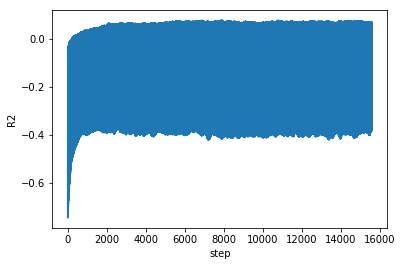

In [10]:
plt.plot(step_list,test_r2_list)
plt.xlabel("step")
plt.ylabel("R2")
plt.show()

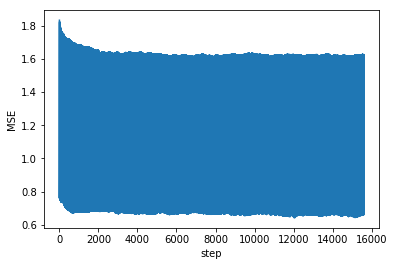

In [11]:
plt.plot(step_list,test_mse_list)
plt.xlabel("step")
plt.ylabel("MSE")
plt.show()

In [ ]:
df = pd.DataFrame(data=(step_list,test_r2_list,test_mse_list))